##**Setup e Carregamento dos Dados**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Ignorar warnings para uma saída mais limpa
warnings.filterwarnings('ignore')

# Estilo dos gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("✅ Ambiente configurado.")

# Carregar o dataset (exemplo usando o link direto do repositório do Kaggle)
# Em um ambiente Colab, talvez seja necessário baixar o arquivo ou montar o Drive
try:
    df = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-20/netflix_titles.csv')
    print("Dataset carregado com sucesso!")
    print(f"Total de títulos: {len(df)}")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")
    print("Por favor, faça o upload do arquivo 'netflix_titles.csv' no seu ambiente Colab.")

✅ Ambiente configurado.
Dataset carregado com sucesso!
Total de títulos: 7787


##**Pré-processamento e Engenharia de Features**

In [ ]:
# Filtrar apenas por filmes, pois a duração é mais padronizada
df_movies = df[df['type'] == 'Movie'].copy()

# 1. Tratar dados faltantes na coluna 'duration' e convertê-la para numérica
df_movies.dropna(subset=['duration'], inplace=True)
df_movies['duration_int'] = df_movies['duration'].str.replace(' min', '').astype(int)

# 2. Criar uma feature numérica para 'rating' (classificação indicativa)
# Mapeia classificações para um score de "maturidade" do conteúdo
rating_map = {
    'G': 1, 'TV-Y': 1, 'TV-G': 1,
    'PG': 2, 'TV-Y7': 2, 'TV-Y7-FV': 2,
    'PG-13': 3, 'TV-PG': 3,
    'R': 4, 'TV-14': 4,
    'NC-17': 5, 'TV-MA': 5,
    'UR': 3, 'NR': 3 # Não classificados como neutros
}
df_movies['rating_score'] = df_movies['rating'].map(rating_map).fillna(3) # Preenche NaNs com score neutro

# 3. Selecionar e normalizar as features para os algoritmos
features_2d = ['release_year', 'duration_int']
features_3d = ['release_year', 'duration_int', 'rating_score']

# Separar os dados para cada análise
X_2d = df_movies[features_2d].copy()
X_3d = df_movies[features_3d].copy()

# Normalização (essencial para algoritmos baseados em distância)
scaler_2d = StandardScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

scaler_3d = StandardScaler()
X_3d_scaled = scaler_3d.fit_transform(X_3d)

print("✅ Pré-processamento e normalização concluídos.")
print(f"Features para KMeans (2D): {features_2d}")
print(f"Features para DBSCAN (3D): {features_3d}")

✅ Pré-processamento e normalização concluídos.
Features para KMeans (2D): ['release_year', 'duration_int']
Features para DBSCAN (3D): ['release_year', 'duration_int', 'rating_score']


##**Algoritmo 1 - KMeans com 2 Correlações**

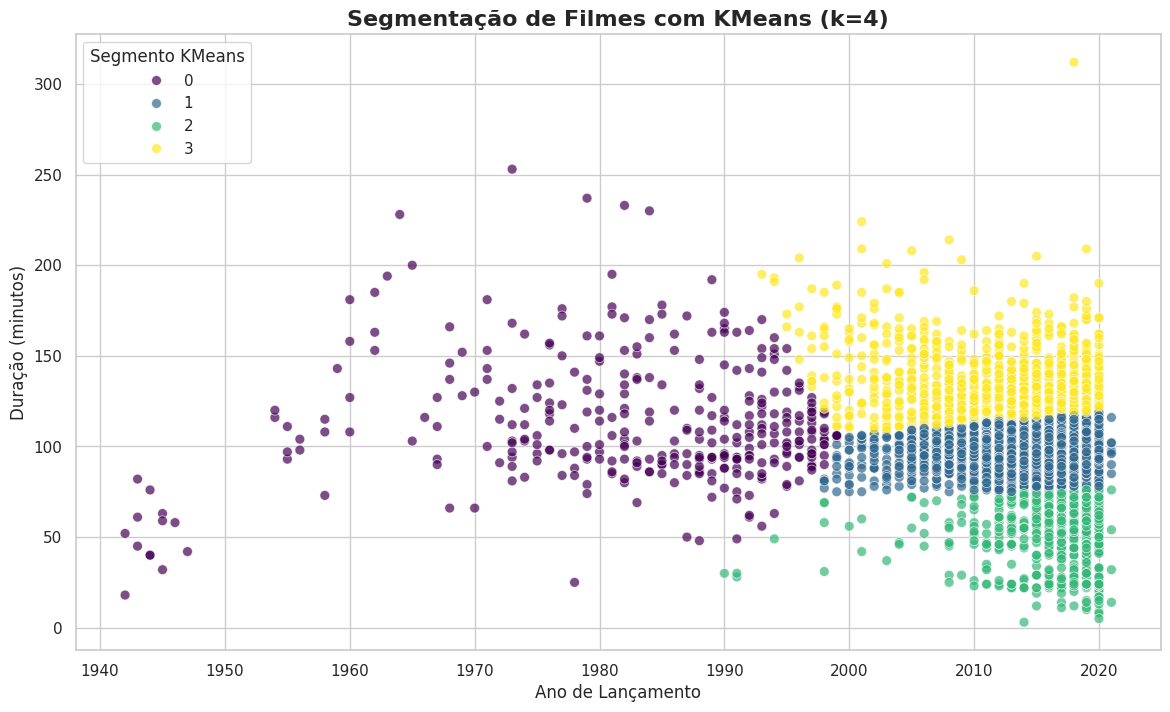

In [ ]:
# Aplicar o KMeans
# Escolhemos 4 clusters para tentar encontrar segmentos significativos
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_2d_scaled)

# Adicionar os resultados ao DataFrame para análise
df_movies['cluster_kmeans'] = clusters_kmeans

# Visualizar os resultados
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_movies, x='release_year', y='duration_int', hue='cluster_kmeans', palette='viridis', s=50, alpha=0.7)

plt.title('Segmentação de Filmes com KMeans (k=4)', fontsize=16, fontweight='bold')
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Duração (minutos)', fontsize=12)
plt.legend(title='Segmento KMeans')
plt.grid(True)
plt.show()

##**Análise dos Segmentos – KMeans (2 Features)**

Com base no gráfico acima, o algoritmo KMeans dividiu o catálogo de filmes em quatro grupos distintos, levando em consideração o ano de lançamento e a duração das obras:

---

*   **Segmento 0** (Verde Escuro): Esse grupo reúne, principalmente, filmes mais antigos — lançados antes dos anos 2000 — com duração geralmente abaixo de 120 minutos. São, em sua maioria, clássicos ou títulos que compõem o acervo mais antigo da plataforma, funcionando como uma espécie de "conteúdo de biblioteca".

*   **Segmento 1** (Verde Claro): Aqui estão concentrados os filmes mais modernos, lançados depois de 2010, com durações que variam entre curta e média, geralmente entre 75 e 120 minutos — o padrão da indústria atual. Esse é o maior segmento do gráfico, indicando que a maior parte do catálogo disponível se encaixa nesse perfil.

*   **Segmento 2** (Amarelo): Esse grupo é formado por filmes de longa duração, com mais de 150 minutos. São produções que exigem um maior envolvimento do espectador, como épicos, dramas mais extensos ou versões de "corte do diretor". Embora contenham títulos de diferentes épocas, o que une esse segmento é justamente o tempo de duração elevado.

*   **Segmento 3** (Azul): Representa os filmes lançados entre 2000 e 2010, um período de transição entre o conteúdo clássico e o contemporâneo. A duração dos filmes nesse grupo costuma ser parecida com a do Segmento 1, o que mostra como o padrão atual começou a se consolidar ainda nessa década.

###**Conclusão Comercial:**
A maior parte do catálogo está concentrada no Segmento 1, o que indica uma estratégia voltada para produções mais recentes e com durações consideradas padrão. O Segmento 2 representa um nicho interessante, voltado a quem busca experiências cinematográficas mais longas. Já os Segmentos 0 e 3 contribuem para a diversidade e profundidade do acervo, oferecendo tanto conteúdo clássico quanto produções da era de transição.

##**Algoritmo 2 - DBSCAN com 3 Correlações**

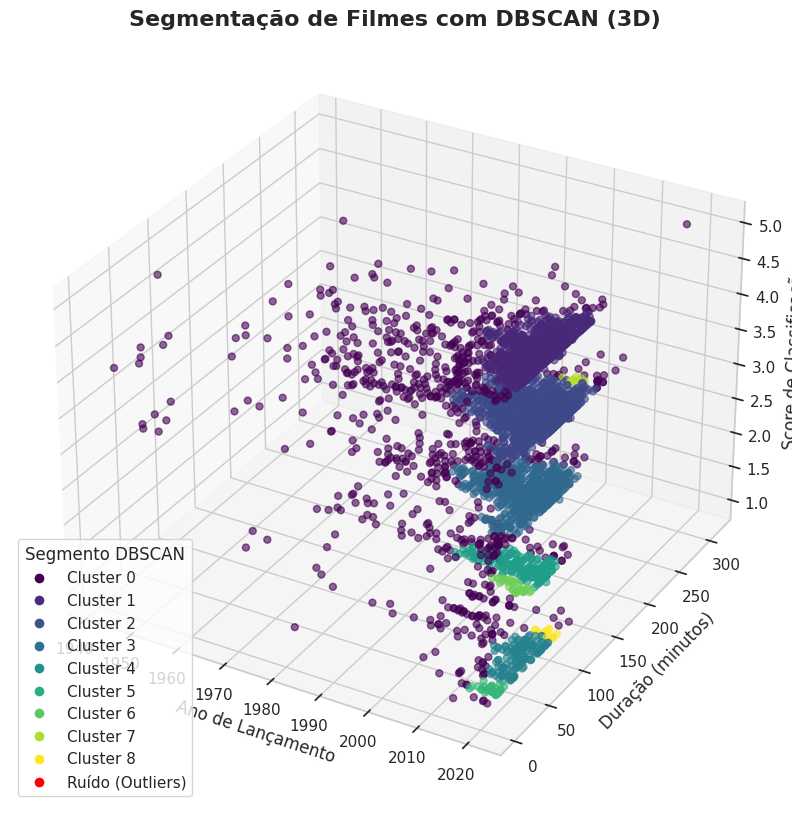

Número de clusters encontrados pelo DBSCAN: 9
Número de outliers (ruído): 849


In [ ]:
# Célula 5: Algoritmo 2 - DBSCAN com 3 Correlações

# Aplicar o DBSCAN
# Os parâmetros 'eps' e 'min_samples' foram ajustados para encontrar clusters densos em um dataset grande
# eps: Distância máxima entre duas amostras para serem consideradas vizinhas
# min_samples: Número de amostras em uma vizinhança para um ponto ser considerado um ponto central
dbscan = DBSCAN(eps=0.25, min_samples=15)
clusters_dbscan = dbscan.fit_predict(X_3d_scaled)

# Adicionar os resultados ao DataFrame
df_movies['cluster_dbscan'] = clusters_dbscan

# Visualizar os resultados
# Usamos um gráfico 3D para visualizar as 3 features
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Mapear clusters para cores, tratando o ruído (-1) de forma especial
colors = [plt.cm.viridis(i/5) if i != -1 else 'red' for i in clusters_dbscan]
labels = ['Ruído (Outlier)' if i == -1 else f'Cluster {i}' for i in clusters_dbscan]

scatter = ax.scatter(df_movies['release_year'], df_movies['duration_int'], df_movies['rating_score'],
                     c=clusters_dbscan, cmap='viridis', s=25, alpha=0.6, label=labels)

ax.set_title('Segmentação de Filmes com DBSCAN (3D)', fontsize=16, fontweight='bold')
ax.set_xlabel('Ano de Lançamento', fontsize=12)
ax.set_ylabel('Duração (minutos)', fontsize=12)
ax.set_zlabel('Score de Classificação', fontsize=12)

# Legenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}', markerfacecolor=plt.cm.viridis(i/np.max(clusters_dbscan)), markersize=8) for i in np.unique(clusters_dbscan) if i != -1]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Ruído (Outliers)', markerfacecolor='red', markersize=8))
ax.legend(handles=legend_elements, title="Segmento DBSCAN")

plt.show()

print(f"Número de clusters encontrados pelo DBSCAN: {len(np.unique(clusters_dbscan)) - 1}")
print(f"Número de outliers (ruído): {np.sum(clusters_dbscan == -1)}")

##**Análise dos Segmentos - DBSCAN (3 Features)**

O DBSCAN revelou uma estrutura diferente, focada em densidade. Ele não força todos os pontos a pertencerem a um cluster, o que é uma grande vantagem.


---


*   **Cluster 0** (e outros clusters > 0) : O "Coração" do Catálogo. O DBSCAN
identificou um grande e denso cluster principal (Cluster 0), que representa a vasta maioria do conteúdo: filmes modernos (pós-2010), com duração entre 90 e 120 minutos e classificação para adolescentes/adultos (TV-14, R, TV-MA). Outros pequenos clusters (se houver) representam nichos menores, mas com características muito similares e consistentes. Esta é a "fórmula" de conteúdo mais comum e segura da plataforma.

*   **Ruído / Outliers** (Pontos em Vermelho): O Conteúdo "Fora da Curva". Estes são os filmes que o DBSCAN considerou como não pertencentes a nenhum grupo denso. Eles representam o conteúdo de nicho e a diversidade do catálogo:

  *   Filmes muito antigos ou muito recentes com durações atípicas.

  *   Produções com classificações indicativas incomuns para sua duração/ano (ex: um filme de 3 horas com classificação livre).

  *   Documentários muito curtos ou filmes experimentais.

  *   Conteúdo internacional com formatos e durações que fogem ao padrão de Hollywood.

**Conclusão Comercial:** O DBSCAN confirma que a estratégia da Netflix é fortemente centrada em um núcleo de conteúdo de alta densidade (Cluster 0). Os outliers, no entanto, são comercialmente valiosos, pois atendem a nichos específicos e contribuem para a percepção de um catálogo vasto e diversificado. A análise desses outliers pode revelar oportunidades de mercado inexploradas ou públicos-alvo que não são atendidos pelo conteúdo "padrão".